In [20]:
import pandas as pd
import numpy as np
import cupy as cp

import time
import requests
import datetime 
import logging
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append('C:/Users/dohyu/Desktop/Github/side_proj_fifa')

import matplotlib.pyplot as plt 
import matplotlib as mpl

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns 
import scipy.stats as stats

import xgboost as xgb
import sqlalchemy

from sqlalchemy import create_engine, text

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

In [21]:
def db_conn(_username, _password, _host, _port, _database) : 
    db_engine = sqlalchemy.engine.URL.create(
        drivername = "mysql+pymysql",
        username = _username,
        password = _password,
        host = _host,
        port = _port,
        database = _database,
    )

    return create_engine(db_engine)

In [22]:
engine = db_conn('root', 'Dhyoon96!', '127.0.0.1', 3306, 'side_proj_fco')
df_query = 'SELECT * FROM match_user'

with engine.connect() as connection:
    df1 = pd.read_sql(df_query, con = connection)

df1 = df1[df1['match_endtype'] == 0].reset_index(drop = True) # 정상 종료된 데이터만 사용

# For rate columns (Variables that have 'try' and 'suc' columns)
df1['match_total_pass_rate'] = (df1['match_total_pass_suc'] / df1['match_total_pass_try']).replace(np.nan, 0)

df1['match_total_pass_short_rate'] = (df1['match_total_pass_short_suc'] / df1['match_total_pass_short_try']).replace(np.nan, 0)
df1['match_total_pass_long_rate'] = (df1['match_total_pass_long_suc'] / df1['match_total_pass_long_try']).replace(np.nan, 0)
df1['match_total_pass_through_rate'] = (df1['match_total_pass_through_suc'] / df1['match_total_pass_through_try']).replace(np.nan, 0)

# Rate for inpenaly and outpenalty
df1['match_total_shoot_inpenalty_rate'] = ((df1['match_total_shoot_inpenalty_try']) / (df1['match_total_shoot_inpenalty_try'] + df1['match_total_shoot_outpenalty_try'])).replace(np.nan, 0)
df1['match_total_shoot_outpenalty_rate'] = ((df1['match_total_shoot_outpenalty_try']) / (df1['match_total_shoot_inpenalty_try'] + df1['match_total_shoot_outpenalty_try'])).replace(np.nan, 0)

# For fail columns (Variables that have 'try' and 'suc' columns)
df1['match_total_pass_fail'] = df1['match_total_pass_try'] - df1['match_total_pass_suc']

df1['match_total_pass_short_fail'] = df1['match_total_pass_short_try'] - df1['match_total_pass_short_suc']
df1['match_total_pass_long_fail'] = df1['match_total_pass_long_try'] - df1['match_total_pass_long_suc']
df1['match_total_pass_through_fail'] = df1['match_total_pass_through_try'] - df1['match_total_pass_through_suc']

df1['match_total_shoot_inpenalty_fail'] = df1['match_total_shoot_inpenalty_try'] - df1['match_total_shoot_inpenalty_suc']
df1['match_total_shoot_outpenalty_fail'] = df1['match_total_shoot_outpenalty_try'] - df1['match_total_shoot_outpenalty_suc']

In [24]:
df1.T

,0,1,2,3,4,5,6,7,8,9,...,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446
match_id,6770ca467705eaf9e115599b,6770ca4754c99dc9780d870b,6770ca4754c99dc9780d870b,6770ca477d00879b1fc04dbd,6770ca477d00879b1fc04dbd,6770ca47ccb3e5542215a430,6770ca47ccb3e5542215a430,6770ca4850e96ba4e2b78d18,6770ca4850e96ba4e2b78d18,6770ca4861fc0e4a3e915dda,...,677e1fd3ef5e27c9d7388965,677e1fd3ef5e27c9d7388965,677e1fd3f36d0a1d0e9d1e49,677e1fd3f36d0a1d0e9d1e49,677e1fd416686ec593283639,677e1fd416686ec593283639,677e1fd43ddba839579a4be1,677e1fd43ddba839579a4be1,677e1fd46641193ca59d1134,677e1fd46641193ca59d1134
user_ouid,198f4cf7dec8af391eb48ed4a8a30533,4bfdd3bc98695f1af5cc8c57cfde75dc,e46c0a63ae73d487734c8e3412dd260b,75a1c9e9fad68338d41a505cdb403592,7fb6fb2e3c049536c9d1357c80ceeca5,41b0515ab81b0872960adc4cc6aa1c3b,55876433d0e7173b882e7e274b772196,00e17418c19e6b5dc9741b961173590d,054d78660bc785072aad3e1da5873487,4203f6ea50759e3ef15c482345a6b6d9,...,2388ef6ca3d2fc1e712aa5f37f7ed909,9254fe2956104a2546bef2c0b3a6ed47,8d4e7cade04bb5748b45058a29f340f8,914d13454a73a68016c1fd5be68016db,c7b4a5755c3e2cd07f54b1b1d29e2711,c8a0cd3685cad6244168523a98e121f9,76b583561827f07078db5b00bfaf5421,833e7c9678986c7907194d9755c037ff,3c92896ed011f98bc40aef18a9b8952e,d57f43d51cf977a9580ece6a0ab8a862
user_nickname,근사한트롤3,난히덩크,이스라엘만세,정용맘,베르모,흥민형팬티속내손,노랑색훈이,귀신잡는즐라탄,고려대23학번영성,내꼬꼬는커요,...,뮌헨최강챔스우승,서승우삼겹살,SCHONG,소하고토레스,황의조급,어쩔리카노,고구마농장주,뷁뷁뷁뷁뷁뷁,구0단0주,뽀시래기의그날
match_result,승,승,패,무,무,패,승,패,승,패,...,패,승,패,승,승,패,승,패,패,승
match_endtype,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
match_possession,75,55,45,53,47,51,49,51,49,51,...,52,48,50,50,52,48,54,46,48,52
match_avg_rating,4.64444,4.43333,4.06111,4.11667,5.21111,3.93333,4.18333,3.98889,4.42778,3.49444,...,3.78889,4.68333,4.01111,4.16111,4.46667,3.85,4.46111,4.01111,4.09444,4.25556
match_total_dribble,64,55,47,71,62,81,73,67,76,58,...,82,49,70,63,57,68,81,69,65,83
match_total_pass_try,91,75,89,109,95,125,105,118,103,72,...,133,68,89,94,68,80,150,101,108,110
match_total_pass_suc,83,63,75,96,86,116,95,97,87,58,...,117,58,71,76,62,71,139,85,93,97


In [29]:
try_col = ['match_total_pass_try',                 
           'match_total_pass_short_try',
           'match_total_pass_long_try',
           'match_total_pass_through_try',
           'match_total_shoot_outpenalty_try',
           'match_total_shoot_inpenalty_try']     


fail_col = ['match_total_pass_fail',
            'match_total_pass_short_fail',
            'match_total_pass_long_fail',
            'match_total_pass_through_fail',
            'match_total_shoot_outpenalty_fail',
            'match_total_shoot_inpenalty_fail'] 

basic_col = ['match_total_dribble',
             'match_total_shoot', 
             'match_total_pass_try',
             'match_possession']


# RandomForest Classifier

In [86]:
def random_forest_classifier(_df, _col) : 
    df_temp = _df[_col]
    df_temp = df_temp[((_df['match_result'] == '승') | (df_temp['match_result'] == '패'))].reset_index(drop = True)

    df_temp['match_result'] = df_temp['match_result'].map({'승': 1, '패': 0})

    X = df_temp.drop('match_result', axis = 1)
    y = df_temp['match_result']

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                      test_size = 0.2, 
                                                      random_state = 42, 
                                                      stratify = y)

    pipeline_rfc = Pipeline([
        ('scaler', MinMaxScaler()),
        ('rfc', RandomForestClassifier(random_state = 42))
    ])

    print('Model Random Forest Classifier with Column:', _col)

    param_grid_rfc = {
        'rfc__n_estimators': [50, 100, 150],
        'rfc__max_depth': [2, 5, 10],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__bootstrap': [True, False]
    }

    kf_rfc = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    grid_search_rfc = GridSearchCV(estimator = pipeline_rfc,
                                   param_grid = param_grid_rfc,
                                   cv = kf_rfc,
                                   verbose  = 2,
                                   n_jobs = -1)

    grid_search_rfc.fit(X_temp, y_temp)

    best_model_rfc = grid_search_rfc.best_estimator_

    y_test_pred_rfc = best_model_rfc.predict(X_test)
    y_test_pred_proba_rfc = best_model_rfc.predict_proba(X_test)[:, 1]

    test_result_rfc = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_test_pred_rfc
    })

    cm_rfc = confusion_matrix(y_test, y_test_pred_rfc)
    
    fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_test_pred_proba_rfc)
    roc_auc_score_rfc = roc_auc_score(y_test, y_test_pred_proba_rfc)

    print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_rfc))
    print("\nClassification Report on Test Set_RFC:\n", classification_report(y_test, y_test_pred_rfc))

    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')

    feature_importance_avg_rfc = best_model_rfc.named_steps['rfc'].feature_importances_
    sorted_idx_rfc = feature_importance_avg_rfc.argsort()

    plt.figure(figsize = (12, 4))
    plt.barh(X.columns[sorted_idx_rfc], feature_importance_avg_rfc[sorted_idx_rfc])
    plt.xlabel("Average Feature Importance (Random Forest Classifier)")
    plt.title("Feature Importance Across K-Folds_RFC")

    plt.tick_params(axis = 'y', labelsize = 5)  
    plt.tick_params(axis = 'x') 

    for i, v in enumerate(feature_importance_avg_rfc[sorted_idx_rfc]):
        plt.text(v + 0.001, i, str(round(v, 3)), color = 'black', va = 'center', fontsize = 'small')
    
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    
    disp_rfc = ConfusionMatrixDisplay(confusion_matrix = cm_rfc, display_labels = best_model_rfc.classes_)
    disp_rfc.plot(cmap = 'Blues', ax = axes[0], values_format = 'd', colorbar = False)    
    axes[0].set_title("Confusion Matrix for Test Data_RFC")

    axes[1].plot(fpr_rfc, tpr_rfc, 
                 label = 'Random Forest Classifier (AUC = %0.3f)' % roc_auc_score_rfc)
    axes[1].plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic Curve')
    axes[1].legend(loc = 'lower right')

    plt.tight_layout()
    plt.show()

Model Random Forest Classifier with Column: ['match_total_shoot', 'match_total_pass_long_try', 'match_total_pass_fail', 'match_total_shoot_outpenalty_try', 'match_total_pass_long_fail', 'match_total_dribble', 'match_total_pass_try', 'match_possession', 'match_total_pass_short_fail', 'match_total_shoot_inpenalty_fail', 'match_total_shoot_inpenalty_try', 'match_total_pass_through_try', 'match_total_shoot_outpenalty_fail', 'match_total_pass_through_fail', 'match_result', 'match_total_pass_short_try']
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Test Accuracy: 0.696969696969697

Classification Report on Test Set_RFC:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68       115
           1       0.69      0.73      0.71       116

    accuracy                           0.70       231
   macro avg       0.70      0.70      0.70       231
weighted avg       0.70      0.70      0.70       231

--------------------------------

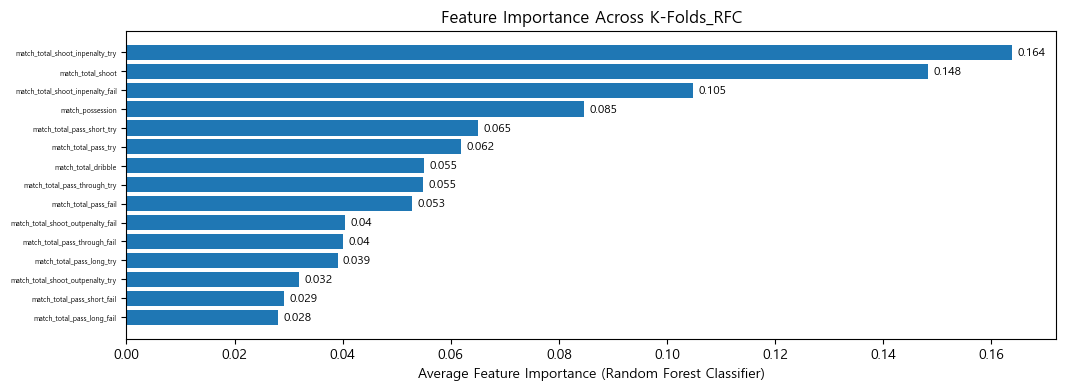

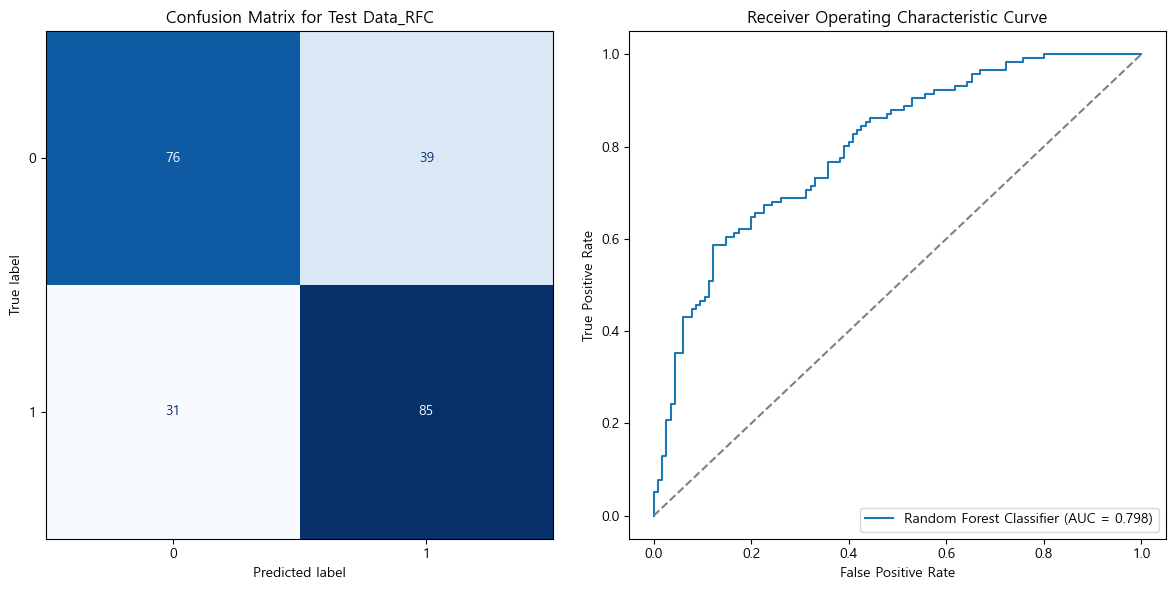

In [87]:
# Columns with try_col, fail_col, basic_col 
df_col_temp = list(set(['match_result'] + try_col + fail_col + basic_col))

random_forest_classifier(df1, df_col_temp)

Model Random Forest Classifier with Column: ['match_total_shoot_eff', 'match_total_pass_short_fail', 'match_total_shoot_inpenalty_fail', 'match_total_pass_long_rate', 'match_result', 'match_total_shoot_outpenalty_rate', 'match_total_pass_through_fail']
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Test Accuracy: 0.670995670995671

Classification Report on Test Set_RFC:
               precision    recall  f1-score   support

           0       0.69      0.62      0.65       115
           1       0.66      0.72      0.69       116

    accuracy                           0.67       231
   macro avg       0.67      0.67      0.67       231
weighted avg       0.67      0.67      0.67       231

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


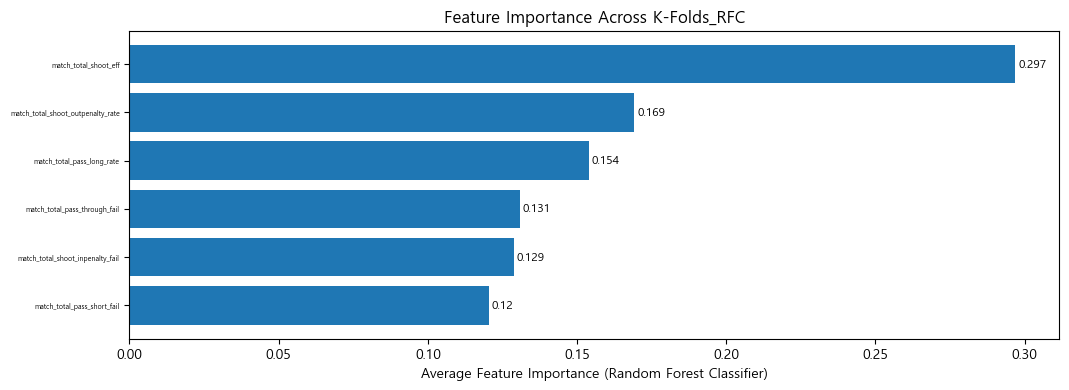

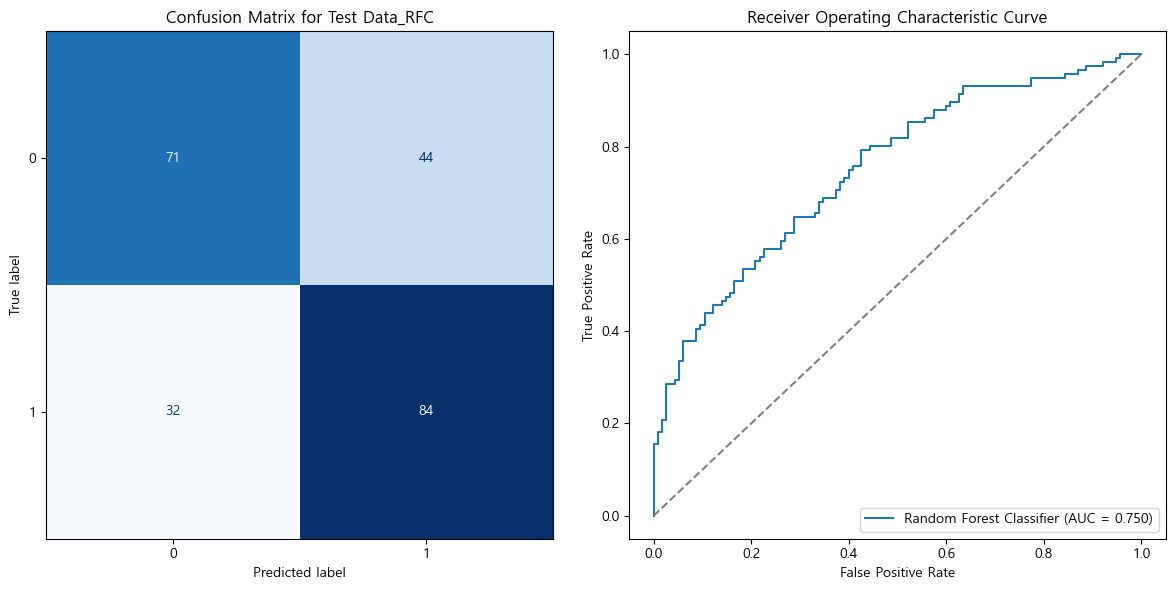

In [88]:
# Columns from match_user_visualization
df_col_temp = list(set(['match_result'] + ['match_total_shoot_eff',
                                           'match_total_pass_short_fail',
                                           'match_total_pass_through_fail',
                                           'match_total_shoot_inpenalty_fail',
                                           'match_total_pass_long_rate',
                                           'match_total_shoot_outpenalty_rate']))

random_forest_classifier(df1, df_col_temp)

# XGBoost Classifier with K-fold, GridSearch

In [58]:
from sklearn.pipeline import Pipeline

In [89]:
def xgboost_classifier(_df, _col) : 
    df_temp = _df[_col]
    df_temp = df_temp[((_df['match_result'] == '승') | (df_temp['match_result'] == '패'))].reset_index(drop = True)

    df_temp['match_result'] = df_temp['match_result'].map({'승': 1, '패': 0})

    X = df_temp.drop('match_result', axis = 1)
    y = df_temp['match_result']

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                      test_size = 0.2, 
                                                      random_state = 42, 
                                                      stratify = y)

    pipeline_xgb = Pipeline([
        ('scaler', MinMaxScaler()),
        ('xgb', xgb.XGBClassifier(
            tree_method = 'hist', eval_metric = "logloss", use_label_encoder = False, random_state = 42))
        ])

    print('Model XGBoost Classifier with Column:', _col)

    param_grid_xgb = {
        'xgb__n_estimators': [50, 100, 150],
        'xgb__max_depth': [2, 3, 5],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.8, 0.9],
        'xgb__colsample_bytree': [0.8, 1.0]
    }

    kf_xgb = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    grid_search_xgb = GridSearchCV(estimator = pipeline_xgb, 
                                   param_grid = param_grid_xgb, 
                                   cv = kf_xgb, 
                                   verbose = 2, 
                                   n_jobs = -1)

    grid_search_xgb.fit(X_temp, y_temp)
    
    print("Best parameters found: ", grid_search_xgb.best_params_)
    print("Best cross-validation score: ", grid_search_xgb.best_score_)

    best_model_xgb = grid_search_xgb.best_estimator_

    y_test_pred_xgb = best_model_xgb.predict(X_test)
    y_test_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]

    test_result_xgb = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_test_pred_xgb
    })

    cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

    fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_test_pred_proba_xgb)
    roc_auc_score_xgb = roc_auc_score(y_test, y_test_pred_proba_xgb)

    print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
    print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred_xgb))

    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')

    feature_importance_avg_xgb = best_model_xgb.named_steps['xgb'].feature_importances_
    sorted_idx_xgb = feature_importance_avg_xgb.argsort()

    plt.figure(figsize = (10, 8))
    plt.barh(X.columns[sorted_idx_xgb], feature_importance_avg_xgb[sorted_idx_xgb])
    plt.xlabel("Average Feature Importance (XGBoost)")
    plt.title("Feature Importance Across K-Folds_XGB")

    plt.tick_params(axis = 'y', labelsize = 5)  
    plt.tick_params(axis = 'x')  

    for i, v in enumerate(feature_importance_avg_xgb[sorted_idx_xgb]):
        plt.text(v + 0.001, i, str(round(v, 3)), color = 'black', va = 'center', fontsize = 'small')

    plt.show()

    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    
    disp_xgb = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = best_model_xgb.classes_)
    disp_xgb.plot(cmap = 'Blues', ax = axes[0], values_format = 'd', colorbar = False)    
    axes[0].set_title("Confusion Matrix for Test Data_XGB")

    axes[1].plot(fpr_xgb, tpr_xgb, 
                 label = 'XGBoost Classifier (AUC = %0.3f)' % roc_auc_score_xgb)
    axes[1].plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic Curve')
    axes[1].legend(loc = 'lower right')

    plt.tight_layout()
    plt.show()

Model XGBoost Classifier with Column: ['match_total_shoot', 'match_total_pass_long_try', 'match_total_pass_fail', 'match_total_shoot_outpenalty_try', 'match_total_pass_long_fail', 'match_total_dribble', 'match_total_pass_try', 'match_possession', 'match_total_pass_short_fail', 'match_total_shoot_inpenalty_fail', 'match_total_shoot_inpenalty_try', 'match_total_pass_through_try', 'match_total_shoot_outpenalty_fail', 'match_total_pass_through_fail', 'match_result', 'match_total_pass_short_try']
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Best cross-validation score:  0.7586545240893068

Test Accuracy: 0.7532467532467533

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       115
           1       0.75      0.76      0.76       116

   

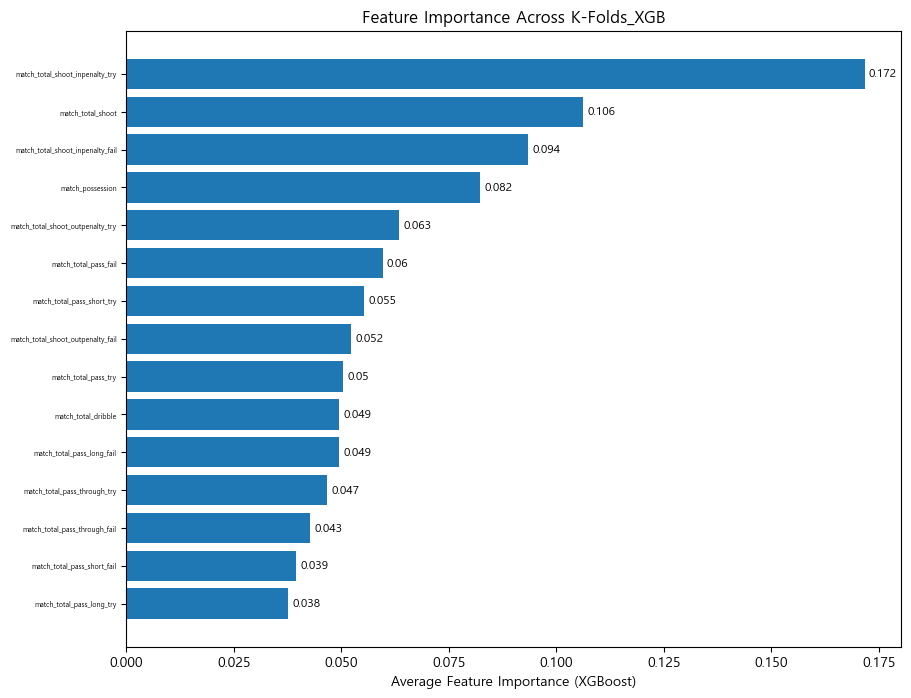

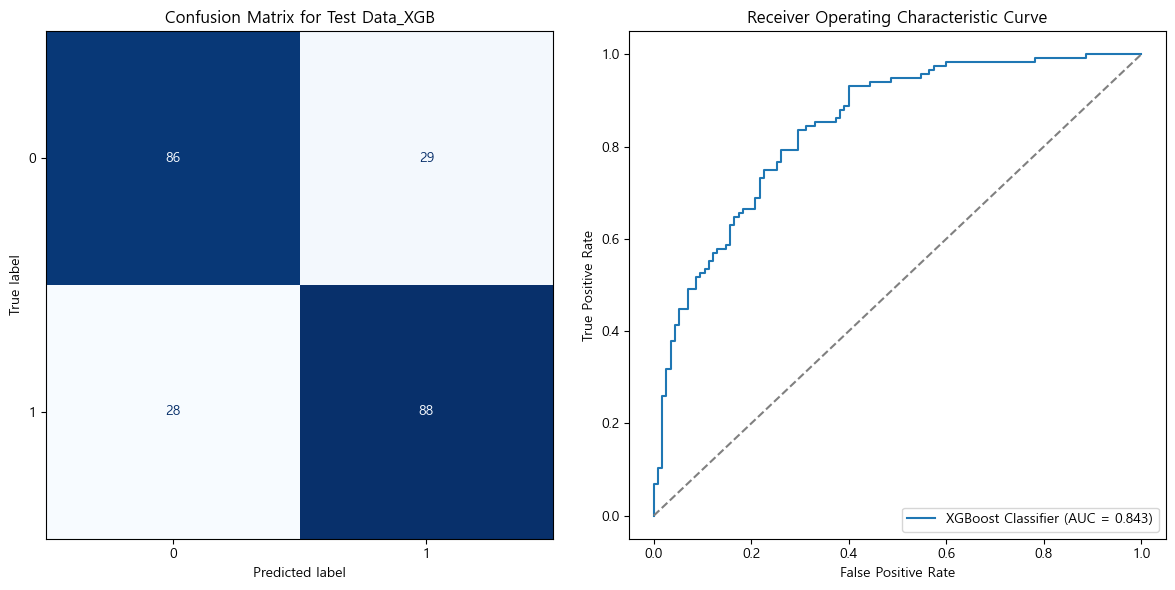

In [90]:
# Columns with try_col, fail_col, basic_col 
df_col_temp = list(set(['match_result'] + try_col + fail_col + basic_col))

xgboost_classifier(df1, df_col_temp)

Model XGBoost Classifier with Column: ['match_total_shoot_eff', 'match_total_pass_short_fail', 'match_total_shoot_inpenalty_fail', 'match_total_pass_long_rate', 'match_result', 'match_total_shoot_outpenalty_rate', 'match_total_pass_through_fail']
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.9}
Best cross-validation score:  0.7229553466509988

Test Accuracy: 0.7186147186147186

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       115
           1       0.71      0.73      0.72       116

    accuracy                           0.72       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.72      0.72      0.72       231

------------------------------------------------------------------------------------------

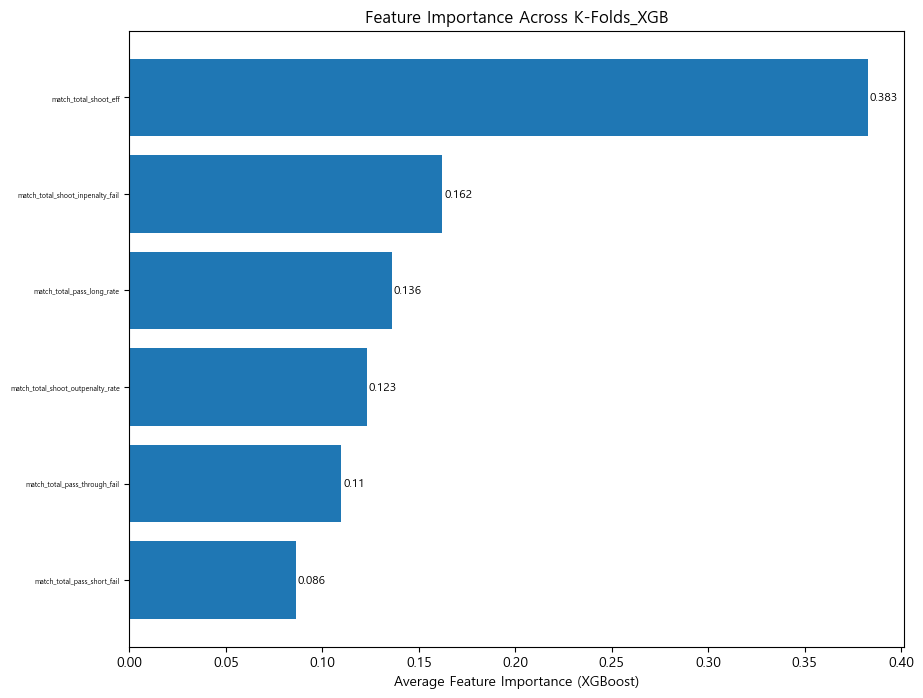

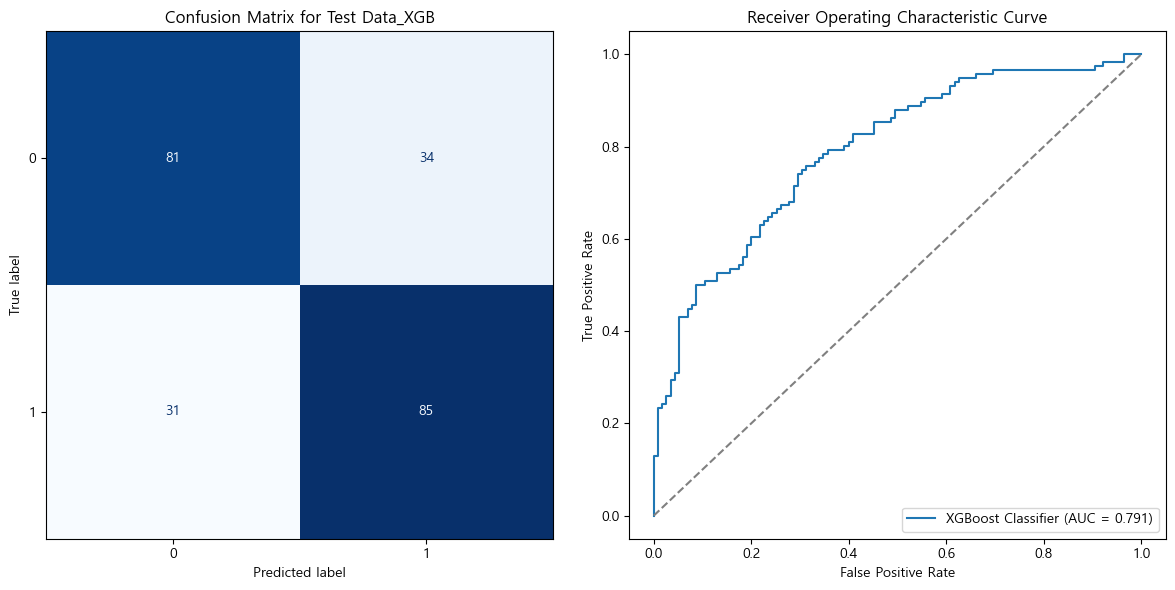

In [91]:
# Columns from match_user_visualization
df_col_temp = list(set(['match_result'] + ['match_total_shoot_eff',
                                           'match_total_pass_short_fail',
                                           'match_total_pass_through_fail',
                                           'match_total_shoot_inpenalty_fail',
                                           'match_total_pass_long_rate',
                                           'match_total_shoot_outpenalty_rate']))

xgboost_classifier(df1, df_col_temp)